# Слияние модальностей

В агента будут подаваться текстовая инструкция и история наблюдений (изображения). Текстовая инструкция необходима для уточнения действий агента. Вот схема подачи текста и изображений:

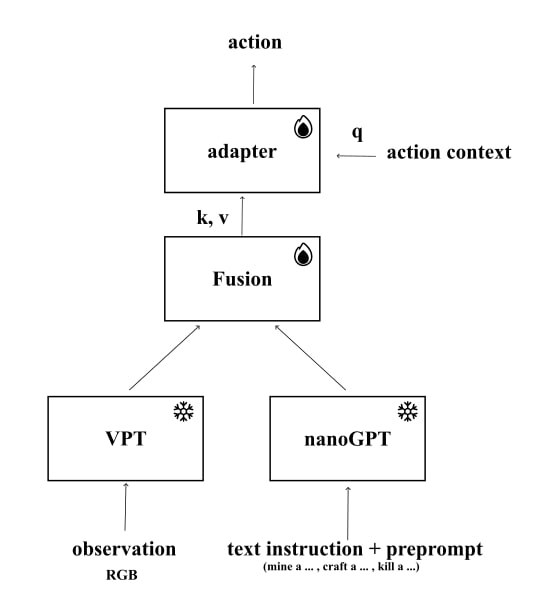

## Механизм слияния и интерпретация признаков

Признаки из текста и изображений будут извлекаться бэкбонами. Для удобства работы с моделью нужно объединить эти признаки в единое пространство. По [обзору](https://dl.acm.org/doi/pdf/10.1145/3649447) принято решение использовать cross-attention как механизм слияния модальностей. Он выбран по двум причинам:

1. Простота реализации
2. В среднем показывает лучшие результаты

Для этого будет необходимо написать небольшую модель в виде энкодера-трансформера. В моём предположении изображения представляют больше информации: на изображениях слишком много объектов: окружение, интерфейс, предметы в руках, мобы. В свою очередь текст задаёт конкретную задачу и уточняет, на что стоит обращать внимание в наблюдениях.

В таком случае текст можно интерпретировать как query, а изображения как key и value.

## Используемые токены

Во время обучения и инфиренса мы будем подавать наблюдения, увеличивая контекст с каждым шагом, добавляя новую информацию (новые изображения и историю действий), однако инструкция всегда будет зафиксирована. Модели типа vpt и gpt используют последний токен для принятия решений. После механизма внимания этот токен аккумулирует информацию о предыдущих токенах.

В нашем случае кажется, что для использования текстовой информации, можно использовать просто последний токен. В случае визуальной модальности лучше использовать все токены, чтобы модель лучше использовала информацию о динамике среды.

Итого предлагается брать из текстовой модальности последний токен, а из визуальной все токены.

## Принципиальная схема

Размерности текстового и визуальных латентов необходимо свести к одной размерности d. Если текст это запрос, то Q имеет размерность (B, T, d), K и V берутся из изображений, тогда их размерность (B, T, d). После всех перемножений получаем тензор (B, 1, d). Имплементируем слияние в виде трансформера.

Вот общая схема

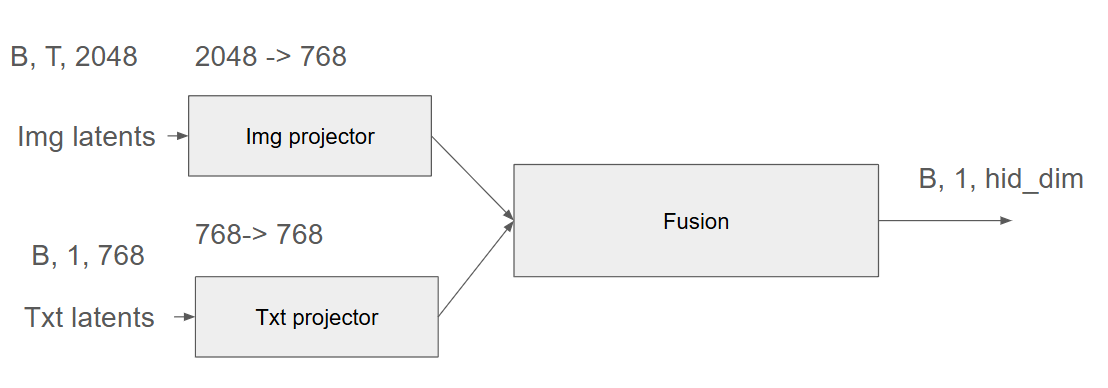

Сперва реализуем модули проекции. Для текста также сделаем модуль, если в будущем возникнет возможность изменить размерность. Это поможет нам перевести модальности из их абстрактных пространств в общее абстрактное пространство. Пока сделаем оба проектора из одного линейного слоя каждый.

In [ ]:
from dataclasses import dataclass
import torch.nn as nn
import torch

class VisionProjector(nn.Module):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.proj = nn.Linear(config.img_latent_dim, config.proj_dim, bias=False)
        
    def forward(self, x):
        return self.proj(x)

class TextProjector(nn.Module):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.proj = nn.Linear(config.txt_latent_dim, config.proj_dim, bias=False)
        
    def forward(self, x):
        return self.proj(x)
    
@dataclass
class Config:
    img_latent_dim : int = 2048
    txt_latent_dim : int = 768
    proj_dim : int = 768

Теперь реализуем оставшуюся часть механизма слияния. Сделаем вот по такой схеме:

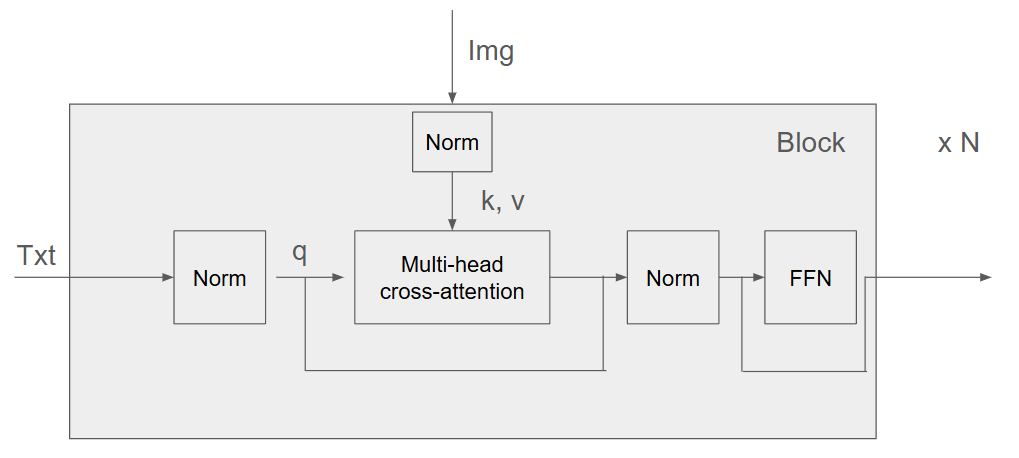

Будет N последовательных блоков, в каждом блоке будет двунаправленный cross-attention. Выход предыдущего блока идёт на вход следующего, мы каждый раз будем обновлять Q, а K,V всегда будут формироваться из визуальных латентов с проектора.

In [ ]:
import torch.nn as nn
import torch


class ModalityFusor(nn.Module):
    def __init__(self, config, *args, **kwargs):
        super().__init__(*args, **kwargs)
    